M2L School 2025 Edition in Split, Croatia.

This tutorial is based on:
*   Explanations and code snippets from the [2024 edition](https://github.com/M2Lschool/tutorials2024/tree/main/4_rl)
*   Explanations and code snippets from Huggingface TRL tutorials [GRPO](https://huggingface.co/learn/cookbook/en/fine_tuning_llm_grpo_trl).

Notebook Author: Yuqing Du

---
# RL03: Reinforcement Learning from (Any-) Feedback
---

Welcome to the last part of the RL Lab @ M2L 2025!

This notebook introduces you to an emergent research topic that merges two communities: Natural Language Processing and Reinforcement Learning. **But why?** Language models have become pervasive in research and beyond; while there is a huge knowledge gain in training from internet-scale data, it has become necessary to polish LMs towards desirable properties defined by humans, such as:


*   Politeness
*   Usefulness
*   Harmlessness
*   Impartiality
*   Reasoning

But how to define loss functions for these concepts? The traditional pre-training paradigm for LMs is not sufficient: reinforcement learning becomes useful to make these models optimize for **reward functions** that represent complex concepts. One class of reward functions is based in **verfiable rewards**, in other words, cases where it is possible to calculate a ground truth answer and verify whether the LLM output is correct or not. This is similar to the reward functions we explored in the prior exercises where we design a function (e.g. in code) that outputs a reward score based on how close the LLM answer is to the verifiable ground truth; this practice is typically referred to as **reinforcement learning** from **verifiable feedback** (RLVF).  

However, there are also many cases where we would like to guide LLM behaviour without an exact ground truth -- for example, to increase helpfulness and politeness. In these cases where we cannot write a function that measures these properties exactly, we develop reward models as data-driven models that reflect examples annotated by humans; this practice is typically referred to as **reinforcement learning** from **human (collected) feedback** (RLHF).

The main pipeline for RLHF consists of:
1.   Pre-trained LM to start from, e.g. [GPT-3](https://arxiv.org/abs/2005.14165).
2.   Reward model trained on datasets specific for our desired property, e.g. [DistilBERT for sentiment analysis](https://huggingface.co/lvwerra/distilbert-imdb).
3.   Fine-tuning of the pre-trained LM with a RL algorithm, e.g. [PPO](https://arxiv.org/abs/1707.06347) or [REINFORCE](https://arxiv.org/abs/2010.11364).

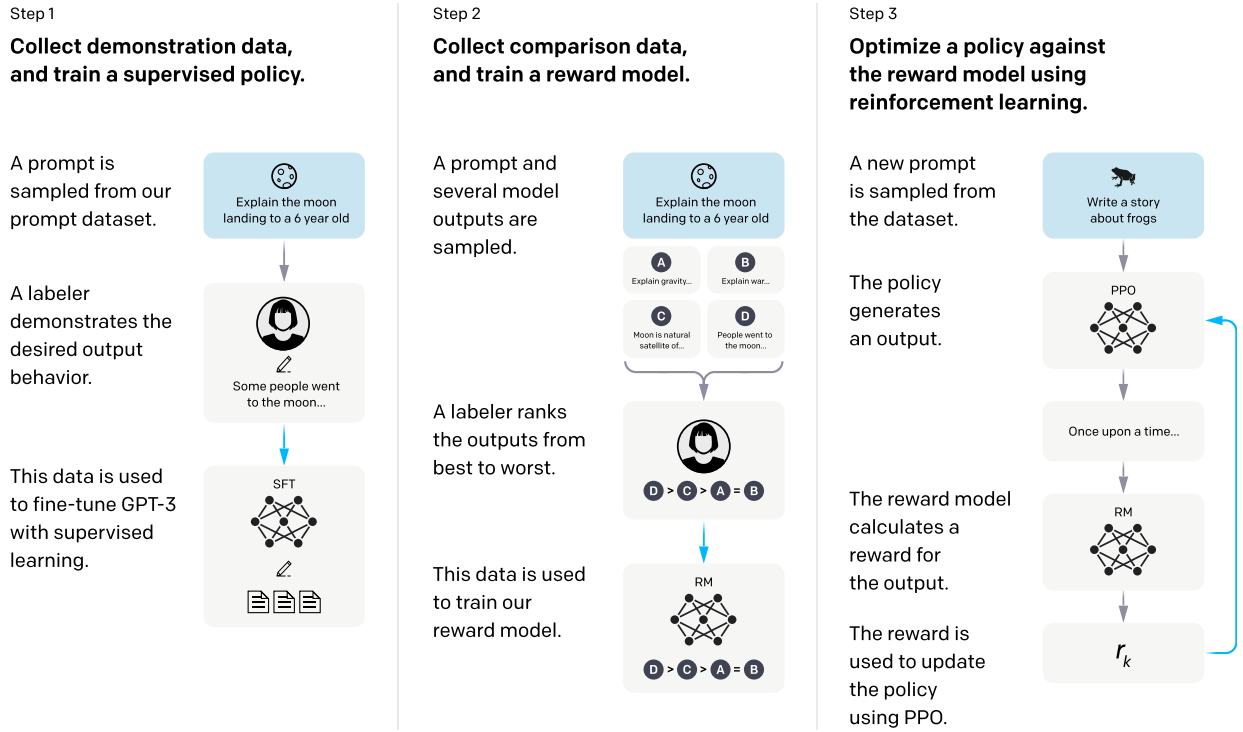













Source: [Ouyang et al. 2022](https://arxiv.org/pdf/2203.02155).

In this tutorial we will implement certain components of this pipeline and explore different methods for carrying out RL*F. There are three main components of this notebook:

1. First we'll take a look at various reward functions that are either based on models of human feedback or ground truth verifiable outputs.

2. Next, we will use an open-source LLM finetuning library to extend policy gradient approaches from Tutorial 2 to LLMs, with a focus on verifiable rewards that have a clear ground truth (i.e. math problems).

3. Finally, we look at the direct preference optimization (DPO) case where we do not use any reward models or signals and train on pairwise preference data directly.

In this colab you will find some

#### ⭐ Exercises
where you need to implement missing parts in the code, or answer the quesions that test your understanding of code and algothims.
When you need to complete some code, the section is marked as:

```
# -----------------------------------#
# You code goes here
# -----------------------------------#
```
with any comments to help you to complete the task. Sometimes it is useful to have a look at further code in the cell to understand which variables you need to assign in your implementation.
Some exercises only require you to answer the questions or experiment with the code.
You can skip bonus exercises if you are short on time as the rest of the content does not depend on them. You can use the Table of content on the left to vavigate the tutorial. Let's begin!


In [ ]:
%%capture
!pip install -q transformers accelerate datasets trl evaluate peft math_verify==0.5.0

In [ ]:
from dataclasses import dataclass, field
from typing import Optional
import torch
import json
import textwrap
import re
from math_verify import LatexExtractionConfig, parse, verify

from datasets import load_dataset
from torch.optim import Adam
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    RobertaForSequenceClassification,
    AutoModelForSequenceClassification,
    RobertaTokenizer,
)
from transformers import set_seed

from trl import (
    AutoModelForCausalLMWithValueHead,
    GRPOConfig, GRPOTrainer,
    DPOConfig, DPOTrainer,
    create_reference_model
)
from trl.core import LengthSampler
from peft import LoraConfig, get_peft_model


tqdm.pandas()

  #### ⭐ Exercise
  With HuggingFace, we can pick any language model from their [library](https://huggingface.co/models) by indicating the endpoint, e.g. `openai-community/gpt2`.

  Change the model endpoint in order to load [Qwen2-0.5B-Instruct (source here)](https://huggingface.co/Qwen/Qwen2-0.5B-Instruct) and fill the blanks to interact with the LM.

In [ ]:
%%capture
# Now let's build the model, the reference model, and the tokenizer.
# We first load the model
# in bfloat16 to save memory using `transformers`.
# -----------------------------------#
model_name = TODO # @param
# -----------------------------------#
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Now write an example prompt and encode it with the `.encode()` function of the tokenizer.

In [ ]:
# -----------------------------------#
in_string = TODO
tokenizer.encode(in_string)
# -----------------------------------#

This is an example snippet of how to tokenize your string, send it to the loaded model, and decode the model outputs.

In [ ]:
in_prompt = tokenizer(in_string, return_tensors="pt")
print(in_prompt)
output = model.generate(**in_prompt, max_length=24)
print(output)
tokenizer.decode(output[0])

Let's make a helper function to output the model completions as well as the full output that we can use in the rest of the notebook.


In [ ]:
# Let's make a helper function to output completions only
def generate_completion(in_string):
  in_prompt = tokenizer(in_string, return_tensors="pt")
  output = model.generate(**in_prompt)
  full_output = tokenizer.decode(output[0])
  # -----------------------------------#
  # Hint: Check the length of your input and the full model output.
  output_truncated = output[0][TODO]
  # -----------------------------------#
  output_truncated = tokenizer.decode(output_truncated)
  return output_truncated, full_output

In [ ]:
# Check that you are getting the completion only.
print(in_string)
generate_completion(in_string)

# Test different reward functions



##  1. Length Reward

#### ⭐ Exercise
To gain some intution for how to set up a reward function, let's look at a simple reward based on completion length. In this case we want to reward the model for generating completions that are close to a short length for brevity.

To test this reward function we can use the [TLDR dataset](https://huggingface.co/datasets/trl-lib/tldr).

In [ ]:
# -----------------------------------#
tldr_dataset_name = TODO # @param
# -----------------------------------#

train_tldr_dataset = load_dataset(tldr_dataset_name, split="train")

In [ ]:
# We can take a look at the data format and number of examples.
print(train_tldr_dataset)

Let's check one example:

In [ ]:
print(json.dumps(train_tldr_dataset[0], indent=2))

In this dataset, the `prompt` is the full chunk of text we would like to provide to an LLM to have it shorten as a 'TL;DR'. The `completion` is an example concise 'TL;DR' output.

Let's pass one of these examples to the LLM we have loaded to see what the output is.

In [ ]:
# -----------------------------------#
# Use the function you implemented above.
model_output = generate_completion(TODO)
# -----------------------------------#

In [ ]:
model_output[0]

Now let's define a simple reward function we can use to evaluate outputs from the model.

In [ ]:
# Since the goal of this task is to generate summarizations, a naive reward would be to generate a reward based on distance from a character length.
# Hint: How can you set up a function such that you get the highest reward when the completion length == desired_length,
# and a lower reward the further you are from desired_length?
def length_reward(completion, desired_length=50):
    # -----------------------------------#
    return TODO
    # -----------------------------------#

In [ ]:
# Test your reward function! Does the reward make sense for the output?
length_reward([model_output[0]])

## 2. Toxicity Reward

In scenarios where we cannot define a function in code for our reward, we can use a trained reward model to score our LLM outputs. This reward model can be a finetuned version of our LLM or a separate model altogether. To train such a reward model, typically we use human annotations.

In this section we'll explore this setup using a smaller language model based on a different architecture, [BERT](https://arxiv.org/abs/1810.04805) (Devlin et al. 2018), that is fine-tuned to classify toxic sentences. Reward models of this type are usually trained from a set of human annotations in order to categorize, rank or score model outputs according to a specified property, e.g. toxicity.

<img width="450px" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/reward-model.png"/>

Source: [Illustrating Reinforcement Learning from Human Feedback (RLHF), HuggingFace](https://huggingface.co/blog/rlhf).

The model we are going to use is `facebook/roberta-hate-speech-dynabench-r4-target`: it consists of a fine-tuned BERT model and a classification head to label text as hate speech or not. This model has been trained by Facebook (Meta) AI, further details can be found [here](https://arxiv.org/pdf/2012.15761)!

In [ ]:
# We first load the toxicity model and tokenizer.
toxicity_model_id = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = RobertaTokenizer.from_pretrained(toxicity_model_id)
# We load the toxicity model in fp16 to save memory.
toxicity_model = RobertaForSequenceClassification.from_pretrained(toxicity_model_id, torch_dtype=torch.float16)

To test this reward model, we load a different dataset `allenai/real-toxicity-prompts` ([source](https://huggingface.co/datasets/allenai/real-toxicity-prompts)), which consists of a collection of prompts and continuations labeled with different toxicity labels.


#### ⭐ Exercise
Many examples in the dataset are neutral, meaning that toxicity scores are low. We need sufficiently informative samples for the LM to learn to avoid toxic content, so in this section we'll implement a filter to better balance the dataset for learning. The method `filter_fn` returns a boolean value (to keep or not to keep) for each sample, keep the ones with valid toxicity (not None) and higher than `0.3`.

In [ ]:
def build_dataset(
    dataset_name="allenai/real-toxicity-prompts", input_min_text_length=5, input_max_text_length=10
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    def filter_fn(sample):
        """ Flags batch samples by custom logic """
        toxicity = sample["prompt"]["toxicity"]
        # -----------------------------------#
        # Implement the filtering discussed above for balancing the dataset.
        return TODO
        # -----------------------------------#

    def tokenize(sample):
        """ Encodes the prompt and the expected continuation """
        prompt = sample["prompt"]["text"]
        continuation = sample["continuation"]["text"]
        # in this task we consider the prompt (neutral) and the continuation (potentially toxic)
        # and see how the model extends the sequence
        sample["input_ids"] = tokenizer.encode(prompt + continuation)[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # preparing the tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    # loading and filtering the dataset with a custom fn
    ds = load_dataset(dataset_name, split="train")
    ds = ds.filter(filter_fn, batched=False)

    # randomly takes a length in within the specified range
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # input the sample tokenization function to process a whole batch
    # -----------------------------------#
    ds = ds.map(TODO, batched=False)
    # -----------------------------------#
    ds.set_format(type="torch")
    ds = ds.train_test_split(test_size=0.2, shuffle=False)["train"]

    return ds

It has been shown [here](https://huggingface.co/docs/trl/en/detoxifying_a_lm#designing-the-problem) that extending the context length makes the model more prone to reveal toxic content.

We pick a random length in the range `[10, 20]`.

In [ ]:
# We retrieve the dataloader by calling the `build_dataset` function.
min_input_length = 10 # @param
max_input_length = 20 # @param
toxicity_dataset = build_dataset(input_min_text_length=min_input_length, input_max_text_length=max_input_length)

Let's load an element from the dataset and see what it contains:

In [ ]:
toxicity_dataset[0]

#### ⭐ Exercise
Now similar to the length reward section, let's pass one of these datapoints into our model and evaluate the reward for its completion.

In [ ]:
# -----------------------------------#
model_output = generate_completion(TODO)
# -----------------------------------#
print(model_output)

In [ ]:
# Pass in the model completion to the reward model and output the score.
# -----------------------------------#
encoded = toxicity_tokenizer(TODO, return_tensors="pt")
output = toxicity_model(TODO)
# -----------------------------------#
logits = output.logits.float()
probs = logits[:].softmax(-1)[0]

print(f"Neutral:\t{probs[0]:.3f}")
print(f"Hate:\t\t{probs[1]:.3f}")

You can test out multiple sentences to see how logits change: the outputs is tensor of shape `(batch_size, 2)` and for each sample, the two logits represent respectively how *neutral* the text is wrt. how *hate speech* it contains. We use the `.softmax()` function here to normalize the logits in `[0, 1]` (let's say probabilities), but we are going to use the raw outputs as fine-tuning turned out to be more stable for us.

## 3. Verifiable Reward

Lastly, let's look at reward functions that are based in verifiable ground truth. These reward functions are typically used for improving model reasoning capabilities for tasks like math and coding, where we can evaluate the model output for correctness. You can read about such an example [here, DeepSeek-R1](https://arxiv.org/pdf/2501.12948).

For this section we will use a math dataset.

In [ ]:
from datasets import load_dataset

dataset_id = 'AI-MO/NuminaMath-TIR'
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:5%]', 'test[:5%]'])

Once again, let's check the structure of the dataset:

In [ ]:
print(train_dataset)

And let's check one sample:

In [ ]:
print(json.dumps(train_dataset[0], indent=2))

#### ⭐ Exercise
We follow the DeepSeek-R1 training procedure where a specific system prompt was used to generate a conversational pipeline that includes reasoning steps. We’ll adapt our dataset to follow this approach, where the model is guided to first think through the problem and then present its answer.

In [ ]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    problem = example["problem"]
    # Set up the dataset such that the SYSTEM prompt is given by the role "system", and the problem is given by the role "user".
    return {
        "prompt": [
            # -----------------------------------#
            {"role": "system", "content": TODO},
            {"role": "user", "content": TODO},
            # -----------------------------------#
        ],
    }

train_dataset = train_dataset.map(make_conversation)
test_dataset = test_dataset.map(make_conversation)

Let's take a look at an example:



In [ ]:
print(json.dumps(train_dataset[0], indent=2))

We'll remove the `messages` and `problem` columns, as we only need the custom `prompt` column and `solution` to verify the generated answer.  

In [ ]:
train_dataset = train_dataset.remove_columns(['messages', 'problem'])
print(train_dataset)

In [ ]:
train_dataset[0]['prompt']

In [ ]:
train_dataset[0]['solution']

#### ⭐ Exercise
For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags. You can find more details [here](https://github.com/huggingface/open-r1/blob/main/src/open_r1/grpo.py). We can simply define and implement these reward functions as generic Python functions.

In this case, we will utilize these reward functions:

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.  

In [ ]:
# How should we specify the reward such that the function returns a reward of 1 if the format is followed and 0 otherwise?
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    # -----------------------------------#
    rewards_list = TODO
    # -----------------------------------#
    return rewards_list

Test the `format_reward` function by writing a completion that gives a reward 1 and a completion that gives a reward 0:

In [ ]:
# -----------------------------------#
successful_completion = [{'content': TODO}]
unsuccessful_completion =  [{'content': TODO}]
# -----------------------------------#

In [ ]:
assert format_reward([successful_completion, unsuccessful_completion]) == [1.0, 0.0]

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct.

In [ ]:
def accuracy_reward(completions, **kwargs):
    """Reward function that checks if the completion is the same as the ground truth."""
    solutions = kwargs['solution']
    completion_contents = [completion[0]["content"] for completion in completions]
    rewards = []
    for content, solution in zip(completion_contents, solutions):
        gold_parsed = parse(solution, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        answer_parsed = parse(content, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        if len(gold_parsed) != 0:
            try:
                # -----------------------------------#
                # Calculate the reward using the answer_parsed and gold_parsed.
                # Hint: use the 'verify' function that we imported.
                rewards.append(TODO)
                # -----------------------------------#
            except Exception:
                # -----------------------------------#
                # What should the reward be if verifying answer_parsed fails?
                rewards.append(TODO)
                # -----------------------------------#
        else:
            # -----------------------------------#
            # What should the reward be if we don't correctly parse an answer?
            rewards.append(TODO)
            # -----------------------------------#
    return rewards

Test the `accuracy_reward` function. We can use an example solution from the dataset as ground truth:

In [ ]:
example_solution = train_dataset[0]['solution']
print(example_solution)

In [ ]:
# -----------------------------------#
successful_completion = [{'content': TODO}]
unsuccessful_completion =  [{'content': TODO}]
# -----------------------------------#

In [ ]:
assert accuracy_reward([successful_completion, unsuccessful_completion], solution=[example_solution, example_solution]) == [1.0, 0.0]

# Post-Training the Base Model Using GRPO
Now that we've explored a few different possible reward functions, let's train our base model using GRPO. For this section we will focus on the verfiable reward setting.

### Configuring LoRA

To finetune, we will configure LoRA -- a parameter efficient finetuning method. This technique will allow us to efficiently fine-tune the model with a reduced number of parameters, enabling faster and more resource-efficient training.

In [ ]:

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

### Configuring GRPO Training Hyperparameters

Next, let's configure the training parameters for GRPO. Time permitting, you can experiment with the `max_completion_length`, `num_generations`, and `max_prompt_length` parameters.

To keep things simple, we’ll start by training for just 50 steps and reducing the `max_completion_length`, `num_generations`, and `max_prompt_length` from their default values.

Specify a suffix for your model_name so you can reload the model to see what it learned!

In [ ]:
from trl import GRPOConfig

YOUR_NAME_HERE = TODO # @param

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir=f"Qwen2-0.5B-GRPO-{YOUR_NAME_HERE}",
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    gradient_accumulation_steps=16,
    max_steps=50,
    bf16=False,

    # Parameters that control de data preprocessing
    max_completion_length=64, # default: 256
    num_generations=4, # default: 8
    max_prompt_length=128, # default: 512

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=False,
    save_strategy="steps",
    save_steps=25,
)

### Training the Model 🏃

Now, let's configure the trainer and start training the model!

#### ⭐ Exercise
In this case, we pass the two reward functions we previously defined to the trainer: the accuracy based reward and the format reward.

In [ ]:
trainer = GRPOTrainer(
    model=model,
    # -----------------------------------#
    # Apply your reward functions from above.
    reward_funcs=[TODO],
    # -----------------------------------#
    args=training_args,
    train_dataset=train_dataset
)

Time to train the model! 🎉

In [ ]:
trainer.train()

Let's load the logged parameters in tensorboard to see how the reward, losses, etc. change throughout training. You can locate the directory the model is saved in by looking at the `Files` folder on the left bar. You should see a folder under `your_model_name/runs/todays_date`, e.g. `/content/Qwen2-0.5B-GRPO-model_name/runs/Sep09_10-56-47_4ebe53e6193d`, to pass to `tensorboard --logdir` below.

You should see a couple of different metrics, search for terms like `reward`.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir TODO

## 4. Check the Model Performance

Let's load the saved model and see what it has and has not learned:

In [ ]:
model_dir = f"/content/Qwen2-0.5B-GRPO-{YOUR_NAME_HERE}/checkpoint-50"

trained_model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_dir)

Let's check one sample from the test set!

In [ ]:
print(json.dumps(test_dataset[0], indent=2))

#### ⭐ Exercise
We'll create a function to interact with the model. In addition to generating the answer, we'll measure the inference duration and count the number of generated tokens. This will give us insights into how much the model has reasoned during generation.

In [ ]:
import time

def generate_with_reasoning(prompt):
  # Build the prompt from the dataset
  prompt = " ".join(entry['content'] for entry in prompt)

  # Tokenize and move to the same device as the model
  inputs = trained_tokenizer(prompt, return_tensors="pt").to(trained_model.device)

  # Generate text without gradients
  start_time = time.time()
  # -----------------------------------#
  with torch.no_grad():
      output_ids = trained_model.generate(TODO)
  # -----------------------------------#
  end_time = time.time()

  # Decode and extract model response
  generated_text = trained_tokenizer.decode(output_ids[0], skip_special_tokens=True)

  # Get inference time
  inference_duration = end_time - start_time

  # Get number of generated tokens
  num_input_tokens = inputs['input_ids'].shape[1]
  # -----------------------------------#
  num_generated_tokens = TODO
  # -----------------------------------#

  return generated_text, inference_duration, num_generated_tokens

Let's generate the answer for that test sample!

In [ ]:
prompt = test_dataset['prompt'][0]
generated_text, inference_duration, num_generated_tokens = generate_with_reasoning(prompt)
print(generated_text)

The model already demonstrates the ability to generate the correct `<think>` and `<answer>` tags, even though the solution itself is incorrect.

Given the inference time and the number of generated tokens, this approach shows potential benefits:

In [ ]:
print(f"Inference time: {inference_duration:.2f} seconds")
print(f"Generated tokens: {num_generated_tokens}")

# DPO

In the previous sections and exercises we have illustrated the traditional RL\*F pipeline, which relies on some reward signal to provide feedback back to the language model. This allows a language model to output with higher probability desired answers that the reward model can indicate. However, training a reward model can introduce complexity in the design phase, and many tasks do not have a verifiable ground truth -- especially if we want our models to learn behaviours beyond math and code. [Rafailov et al.](https://arxiv.org/abs/2305.18290) illustrated that it is possible to optimize a language model **directly** with **preference data**, without having to train or specify a separate reward model with this data!

This is the case for [**Direct Preference Optimization (DPO)**](https://arxiv.org/abs/2305.18290), which leverages an analytical mapping between preference data (desired outcomes vs. rejected ones) and the optimal policy (our target), such that the loss function is expressed only terms of the current policy and the reference.

In this section, we will load a pairwise preference dataset that we train on directly, without having to train a reward model on these pairs first.

<img width="500px" src="https://media.licdn.com/dms/image/D5612AQGdmu9B-4ALNw/article-cover_image-shrink_720_1280/0/1696967299080?e=2147483647&v=beta&t=YfG_BPfZ-iWijJQUeqgNpX5hiqNcjgpJNqEtuWlWqm0"/>

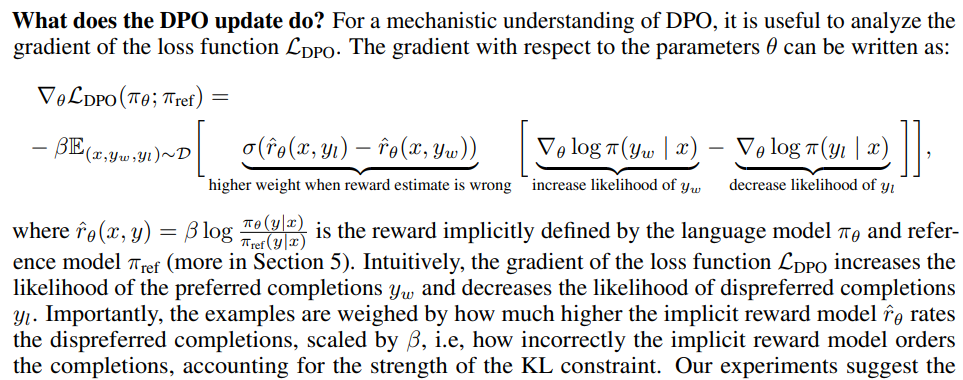

In [ ]:
dpo_dataset_id = 'trl-lib/ultrafeedback_binarized'
train_dpo_dataset, test_dpo_dataset = load_dataset(dpo_dataset_id, split=['train[:5%]', 'test[:5%]'])

In [ ]:
print(train_dpo_dataset)

Let's check one sample. Note that unlike the prior datasets we looked at, here we have two possible completions that are annotated as either `chosen` or `rejected`, where we want to increase the likelihood of generating the `chosen` completion and decrease the likelihood for the `rejected` one.

In [ ]:
print(json.dumps(train_dpo_dataset[0], indent=2))

One new aspect of setting up DPO training is defining a reference copy of the pre-trained LM.

**Why?**

This will allow us to take into account the shift in the language distribution from how the model was initialized. Steering the model too much away may make it output tokens that increase the reward, but may not make much sense; in a way, keeping the fine-tuned model quite similar to the pre-trained version is a tradeoff. Distribution shifts are measured with the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the final reward function will be:

$$
r = r_{\theta} - \lambda \cdot r_{KL}
$$

In the DPO derivation, the reference model is used in the loss as



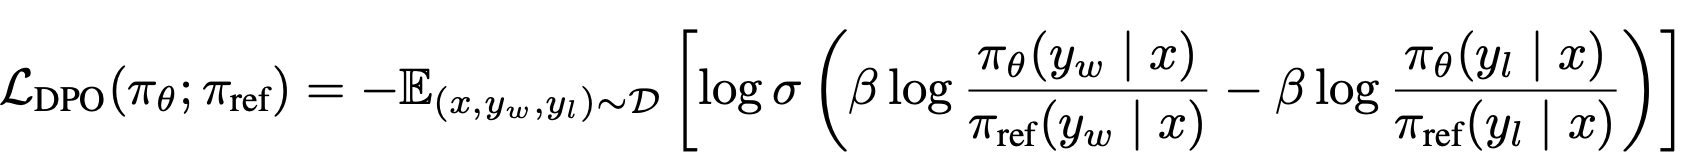

We thus create the reference model as follows:

In [ ]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.bfloat16)

In [ ]:
from trl import DPOConfig

# Configure training arguments using GRPOConfig
dpo_training_args = DPOConfig(
    output_dir=f"Qwen2-0.5B-DPO-{YOUR_NAME_HERE}",
    learning_rate=5.0e-7,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    max_steps=100,
    bf16=False,

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=False,
    save_strategy="steps",
    save_steps=10,
)

#### ⭐ Exercise
Set up the trainer for DPO. As a reference you can use the HuggingFace documentation on DPO and your GRPO code above!

In [ ]:
# -----------------------------------#
trainer = DPOTrainer(
    # Look at the trainer documentation and your GRPO trainer as a point of reference.
    TODO
)
# -----------------------------------#

In [ ]:
trainer.train()

### Drawbacks and proposal for a general approach

RL*F without verifiable rewards using human preferences typically relies on two assumptions: firstly, pairwise preferences can be represented by pointwise rewards; secondly, reward models trained on such pointwise rewards can provide informative feedback to out-of-distribution outcomes generated by the policy. Direct Preference Optimization (DPO) tackles the second assumption.

However, both RLHF and DPO rely on the first assumption through [Bradley-Terry modelisation](https://en.wikipedia.org/wiki/Bradley–Terry_model): this can be problematic as models trained with these methods are more prone to overfitting the preference set, especially when such preferences are (nearly) deterministic.

[Azar et al. 2023](https://arxiv.org/abs/2310.12036) thus propose a general approach, **Identity Preference Optimisation (IPO)**, which introduces the *$\Psi$-preference optimisation objective* ($\Psi\text{PO}$):

$$
\max_{\pi} \mathbb{E}_{\begin{array}{l}
x \sim \rho \\
y \sim \pi(. \mid x) \\
y' \sim \mu(. \mid x)
\end{array}} \left[ \Psi\left(p^{*}(y \succ y' \mid x)\right)\right]
- \tau D_{\text{KL}}\left(\pi \, \| \, \pi_{\text{ref}}\right)
$$

where the net likelihood in the preference pair, $p^*(y \succ y' \mid x)$, is passed to a general non-decreasing function $\Psi(x)$. The authors illustrate that RLHF and DPO are instances of the defined objective and they are empirically inferior to $\Psi\text{PO}$, for $\Psi(x)$ properly formulated.

## Congratulations!! You've reached the end of the RL tutorial 🎉

If you have extra time left, feel free to explore the other parts (1 and 2) if you haven't already, or revisit playing around with different training setups and hyperparameters for GRPO and DPO.